In [0]:
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

## RUN THE ABOVE CELL ONLY ONCE IN A SESSION
It gives you access to your google drive.

In [0]:
!mkdir drive
!google-drive-ocamlfuse drive

mkdir: cannot create directory ‘drive’: File exists


In [0]:
!ls drive/"Colab Notebooks/"

 challenges-in-representation-learning-facial-expression-recognition-challenge
'Confusion Matrix.ipynb'
 model_1.h5
 Training.ipynb


In [0]:
data=pd.read_csv(r'drive/Colab Notebooks/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013/fer2013.csv')

In [0]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
x=([w.split() for w in data['pixels']])

In [0]:
dataset=np.array(x,dtype='int')
dataset.shape

(35887, 2304)

In [0]:
dataset

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 17,  17,  16, ..., 154, 133, 113],
       [ 30,  28,  28, ...,  35,  30,  28],
       [ 19,  13,  14, ..., 189, 199, 201]])

In [0]:
final_data=dataset.reshape(-1, 48, 48, 1)
final_data.shape

(35887, 48, 48, 1)

In [0]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
import keras.metrics

In [0]:
final_data=final_data/255.0

In [0]:
y=np.array(data['emotion'], dtype='float')
X=final_data

In [0]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test=train_test_split(X,y, test_size=0.1)

In [0]:
y_train=to_categorical(y_train, num_classes=7)
y_test=to_categorical(y_test, num_classes=7)

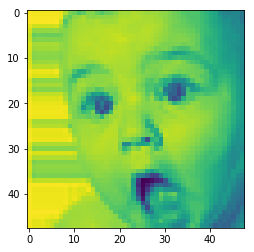

In [0]:
plt.imshow(X_train[1][:,:,0])

In [0]:
keras.backend.clear_session()

W0701 11:51:17.178613 139698027075456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0701 11:51:17.181580 139698027075456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0701 11:51:17.223416 139698027075456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
epochs = 32
batch_size = 128

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [0]:
model=Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(260, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(510, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', 'categorical_accuracy'])

reduction_lr = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=int(1.5*(X_train.shape[0])/ batch_size), callbacks=[reduction_lr])
score = model.evaluate(X_test, y_test, batch_size=128, verbose=1)

W0701 11:51:25.664927 139698027075456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 11:51:25.670452 139698027075456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 11:51:28.610704 139698027075456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0701 11:51:28.680378 139698027075456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0701 11:51:28.688676 139698027075456 deprecation

Epoch 1/32
378/378 [==============================] - 25s 66ms/step - loss: 1.8156 - acc: 0.2509 - categorical_accuracy: 0.2509 - val_loss: 1.7050 - val_acc: 0.3001 - val_categorical_accuracy: 0.3001
Epoch 2/32
378/378 [==============================] - 20s 52ms/step - loss: 1.6969 - acc: 0.3146 - categorical_accuracy: 0.3146 - val_loss: 3.0835 - val_acc: 0.1284 - val_categorical_accuracy: 0.1284
Epoch 3/32
378/378 [==============================] - 19s 51ms/step - loss: 1.5925 - acc: 0.3725 - categorical_accuracy: 0.3725 - val_loss: 1.5135 - val_acc: 0.3984 - val_categorical_accuracy: 0.3984
Epoch 4/32
378/378 [==============================] - 19s 52ms/step - loss: 1.5146 - acc: 0.4122 - categorical_accuracy: 0.4122 - val_loss: 1.5652 - val_acc: 0.3937 - val_categorical_accuracy: 0.3937
Epoch 5/32
378/378 [==============================] - 19s 51ms/step - loss: 1.4474 - acc: 0.4395 - categorical_accuracy: 0.4395 - val_loss: 1.3562 - val_acc: 0.4748 - val_categorical_accuracy: 0.4748


Steps_per_epoch tells how many steps we need per epoch. Since we are augmenting the data I took 1.5 times of the number of images in batch


From stackoverflow: "An epoch usually means one iteration over all of the training data. For instance if you have 20,000 images and a batch size of 100 then the epoch should contain 20,000 / 100 = 200 steps. 

Looks like the accuracy is steadily increasing and there are no signs of overfitting. Let's see if we can train it more and see if we can achieve better results!

In [0]:
further_epochs=15
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = further_epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=int(1.5*(X_train.shape[0])/ batch_size), callbacks=[reduction_lr])
score = model.evaluate(X_test, y_test, batch_size=128, verbose=1)

Epoch 1/15
378/378 [==============================] - 19s 51ms/step - loss: 1.0481 - acc: 0.6047 - categorical_accuracy: 0.6047 - val_loss: 1.0051 - val_acc: 0.6138 - val_categorical_accuracy: 0.6138
Epoch 2/15
378/378 [==============================] - 20s 52ms/step - loss: 1.0422 - acc: 0.6054 - categorical_accuracy: 0.6054 - val_loss: 0.9765 - val_acc: 0.6269 - val_categorical_accuracy: 0.6269
Epoch 3/15
378/378 [==============================] - 19s 51ms/step - loss: 1.0395 - acc: 0.6093 - categorical_accuracy: 0.6093 - val_loss: 0.9896 - val_acc: 0.6244 - val_categorical_accuracy: 0.6244
Epoch 4/15
378/378 [==============================] - 19s 51ms/step - loss: 1.0344 - acc: 0.6076 - categorical_accuracy: 0.6076 - val_loss: 1.0005 - val_acc: 0.6116 - val_categorical_accuracy: 0.6116
Epoch 5/15
378/378 [==============================] - 19s 51ms/step - loss: 1.0315 - acc: 0.6106 - categorical_accuracy: 0.6106 - val_loss: 0.9796 - val_acc: 0.6291 - val_categorical_accuracy: 0.6291


Seems like we have achieved an accuracy of around 63.2%, which is definitely not the best but not far from the state of the art accuracy of Microsoft(around 71.5%) and of other organisations ( around 75%)

In [0]:
from keras.models import load_model

In [0]:
os.chdir("/content/drive/Colab Notebooks")
model.save('model_1.h5')

Text(0.5, 1.0, 'Fear')

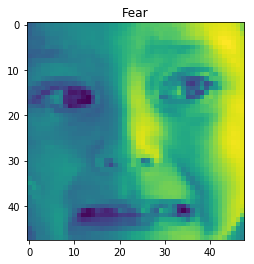

In [0]:
emotions=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plt.imshow(X_test[3].reshape(48,48))
em=emotions[model.predict(X_test[3].reshape(-1,48,48,1)).argmax()]
plt.title(em)